In [1]:
import datetime
import altair as alt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time 
import multiprocessing as mp
from sklearn.decomposition import PCA
char = ['beta','a2me','log_at','ato','beme','c','cto','d2a','dpi2a','e2p','fc2y',
       'free_cf','idio_vol','investment','lev','size','lturnover','noa','oa','ol','pcm',
        'pm','prof','q','rel_to_high_price','rna','roa','roe',
        'cum_return_12_2','cum_return_12_7','cum_return_1_0','cum_return_36_13',
        's2p','sga2s','spread_mean','suv']

df_ = pd.read_csv("../Data/Characteristics Freyberger et al.csv", index_col = 0)
df_['size'] = np.log10(df_['lme'])
df_['log_at'] = np.log10(df_['at'])
df_['sga2s'] = df_['sga2m']/df_['a2me']/df_['ato']
df_.sort_values(by = ['yy', 'mm', 'permno']);

print("Column names:\n", list(df_))
df = df_.iloc[np.random.choice(df_.shape[0], 100),:][['yy','mm','date','permno','ret']+char]
print("Dataframe shape:", df_.shape)
print("Number of unique stocks:", pd.unique(df_['permno']).shape[0])
print("Number of unique dates:", pd.unique(df_['date']).shape[0])
print("Sub-sampled dataframe shape:", df.shape)
df.head()

stocks = pd.unique(df_['permno'])
N = stocks.shape[0]
Ts = pd.unique(df_['date']).tolist()
Ts = [t for t in Ts if not (int(t[-2:])<=70 and int(t[-2:])>=60)]
T = len(Ts)

/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Column names:
 ['yy', 'mm', 'date', 'permno', 'ret', 'q10', 'q20', 'q50', 'prc', 'a2me', 'ato', 'beme', 'c', 'cto', 'd2a', 'dpi2a', 'e2p', 'fc2y', 'free_cf', 'investment', 'lme', 'lturnover', 'noa', 'oa', 'ol', 'pcm', 'pm', 'prof', 'q', 'rna', 'roa', 'roe', 's2p', 'sga2m', 'at', 'beta', 'cum_return_12_2', 'cum_return_12_7', 'cum_return_1_0', 'cum_return_36_13', 'idio_vol', 'spread_mean', 'suv', 'rel_to_high_price', 'lev', 'size', 'log_at', 'sga2s']
Dataframe shape: (1048575, 48)
Number of unique stocks: 7593
Number of unique dates: 623
Sub-sampled dataframe shape: (100, 41)


## Preprocessing Common Stocks and Zts

In [2]:
T = len(Ts)
stocks = np.sort(stocks)
stock_presence = np.empty((stocks.shape[0],T),dtype='bool')
for i_t in range(T): 
    t = Ts[i_t]  # date 
    df_t = df_.loc[df_['date']==t,['yy','permno']]
    stock_presence[:,i_t] = np.isin(stocks,df_t['permno'].unique())
    
# Generate Zt's 
N_s_by_t = []
common_stocks = stocks #np.loadtxt("./common_stocks.csv", dtype=np.int)
start=time.time()
Zts = np.zeros((len(common_stocks),len(char),len(Ts)))
rs = np.zeros((len(common_stocks),len(Ts)))
for i_t in range(T): 
    t = Ts[i_t]  # date 
    df_t = df_.loc[df_['date']==t,['permno','ret']+char]
    #df_t = df_t.loc[df_t['permno'].apply(lambda x: x in set(common_stocks)),:]
    Zt = df_t.sort_values(by="permno")
    if not i_t % 100: print(t, Zt.shape[0])
    N_s_by_t.append(Zt.shape[0])
    # Zts.append(Zt[char])
    Zts[stock_presence[:,i_t],:,i_t] = np.argsort(Zt[char],axis=0)/np.sum(stock_presence[:,i_t])-0.5
    rs[stock_presence[:,i_t],i_t] = df_t['ret']
Zts_save = np.array(Zts, copy=True)
rs_save = np.array(rs,copy=True)
print(np.amax(Zts_save))
print(np.amin(Zts_save))

1/31/71 1191
5/31/79 1464
9/30/87 2587
1/31/96 3088
5/31/04 1575
9/30/12 999
0.49968924798011183
-0.5


In [3]:
Zts = np.array(Zts_save, copy = True)
Zt_cov = np.zeros((Zts.shape[1],Zts.shape[1],Zts.shape[2]))
x_t = np.zeros((Zts.shape[1],Zts.shape[2]))
for i in range(Zts.shape[2]):
    Zt = Zts[:,:,i]
    Zt_cov[:,:,i] = (Zt.T).dot(Zt)
    if i<Zts.shape[2]-1:
        x_t[:,i] = (Zt.T).dot(rs[:,i+1])

## Rolling Window Approach

In [4]:
import numpy as np
import scipy.optimize as sco

def calcPortfolioPerf(weights, meanReturns, covMatrix):
    '''
    Calculates the expected mean of returns and volatility for a portolio of
    assets, each carrying the weight specified by weights

    INPUT
    weights: array specifying the weight of each asset in the portfolio
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio

    OUTPUT
    tuple containing the portfolio return and volatility
    '''    
    #Calculate return and variance

    portReturn = np.sum( meanReturns*weights )
    portStdDev = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights)))

    return portReturn, portStdDev

def negSharpeRatio(weights, meanReturns, covMatrix, riskFreeRate):
    '''
    Returns the negated Sharpe Ratio for the speicified portfolio of assets

    INPUT
    weights: array specifying the weight of each asset in the portfolio
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio
    riskFreeRate: time value of money
    '''
    p_ret, p_var = calcPortfolioPerf(weights, meanReturns, covMatrix)

    return -(p_ret - riskFreeRate) / p_var

def getPortfolioVol(weights, meanReturns, covMatrix):
    '''
    Returns the volatility of the specified portfolio of assets

    INPUT
    weights: array specifying the weight of each asset in the portfolio
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio

    OUTPUT
    The portfolio's volatility
    '''
    return calcPortfolioPerf(weights, meanReturns, covMatrix)[1]

def findMaxSharpeRatioPortfolio(meanReturns, covMatrix, riskFreeRate):
    '''
    Finds the portfolio of assets providing the maximum Sharpe Ratio

    INPUT
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio
    riskFreeRate: time value of money
    '''
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFreeRate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple( (0,1) for asset in range(numAssets))

    opts = sco.minimize(negSharpeRatio, numAssets*[1./numAssets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return opts

In [6]:
%load_ext autoreload
%autoreload 2
from ipca_restricted import ipca_restricted

total_r2_num = 0
total_r2_den = 0
pred_r2_num = 0
pred_r2_den = 0

for K in [2]:
    print("*** K =", K)
    T_window = 120
    fact_ret = np.zeros((K,T-T_window+1))
    port_ret = np.zeros_like(fact_ret)
#     for i_t in range(T_window, T_window+1):
    for i_t in range(T_window,T):
        wind_Zts = np.array(Zts_save[:,:,(i_t-T_window):i_t], copy = True)
        wind_rs = np.array(rs_save[:,(i_t-T_window):i_t],copy=True)
        wind_Zt_cov = Zt_cov[:,:,(i_t-T_window):(i_t-1)]
        wind_x_t = x_t[:,(i_t-T_window):(i_t-1)]
        F_1, Gamma_b_0, max_abs_delta_F, max_abs_delta_Gamma_b,_,_ \
            = ipca_restricted(wind_Zts, wind_Zt_cov, wind_x_t, K, T_window,init=True,tol = 1e-5)
        # Compute out of sample realized factor 
        fact_ret[:,i_t-T_window]= np.linalg.inv((Gamma_b_0.T).dot(wind_Zt_cov[:,:,-1]).dot(Gamma_b_0))\
            .dot(Gamma_b_0.T).dot(wind_Zts[:,:,-1].T).dot(rs_save[:,i_t])
        weights = findMaxSharpeRatioPortfolio(np.mean(F_1,axis=1),np.cov(F_1),0).x
        port_ret[:,i_t-T_window] = weights.dot(fact_ret[:,i_t-T_window])
        total_r2_num += np.linalg.norm(rs_save[:,i_t] - wind_Zts[:,:,-1]\
                                .dot(Gamma_b_0.dot(fact_ret[:,i_t-T_window])))**2
        total_r2_den += np.linalg.norm(rs_save[:,i_t])**2
        pred_r2_num += np.linalg.norm(rs_save[:,i_t] - wind_Zts[:,:,-1]\
                                .dot(Gamma_b_0.dot(np.mean(F_1, axis=1))))**2
        pred_r2_den += np.linalg.norm(rs_save[:,i_t])**2
        print(i_t, end=" => ")
    print("End\n")
    #np.savetxt("./results/fact_ret_restricted_pca_init_K_"+str(K)+".csv", fact_ret, delimiter=",")
    #np.savetxt("./results/fact_ret_restricted_pca_init_R2_K_"+str(K)+".csv", 
#                np.array([1-total_r2_num/total_r2_den, 1-pred_r2_num/pred_r2_den]), delimiter=",")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
*** K = 2
120 => 121 => 122 => 123 => 124 => 125 => 126 => 127 => 128 => 129 => 130 => 131 => 132 => 133 => 134 => 135 => 136 => 137 => 138 => 139 => 140 => 141 => 142 => 143 => 144 => 145 => 146 => 147 => 148 => 149 => 150 => 151 => 152 => 153 => 154 => 155 => 156 => 157 => 158 => 159 => 160 => 161 => 162 => 163 => 164 => 165 => 166 => 167 => 168 => 169 => 170 => 171 => 172 => 173 => 174 => 175 => 176 => 177 => 178 => 179 => 180 => 181 => 182 => 183 => 184 => 185 => 186 => 187 => 188 => 189 => 190 => 191 => 192 => 193 => 194 => 195 => 196 => 197 => 198 => 199 => 200 => 201 => 202 => 203 => 204 => 205 => 206 => 207 => 208 => 209 => 210 => 211 => 212 => 213 => 214 => 215 => 216 => 217 => 218 => 219 => 220 => 221 => 222 => 223 => 224 => 225 => 226 => 227 => 228 => 229 => 230 => 231 => 232 => 233 => 234 => 235 => 236 => 237 => 238 => 239 => 240 => 241 => 242 => 243 => 244 => 245 => 246 => 247 => 248 =>

In [7]:
np.savetxt("./results/port_ret_restricted_pca_init_K_"+str(K)+".csv", port_ret, delimiter=",")
np.savetxt("./results/port_ret_restricted_pca_init_R2_K_"+str(K)+".csv", 
           np.array([1-total_r2_num/total_r2_den, 1-pred_r2_num/pred_r2_den]), delimiter=",")

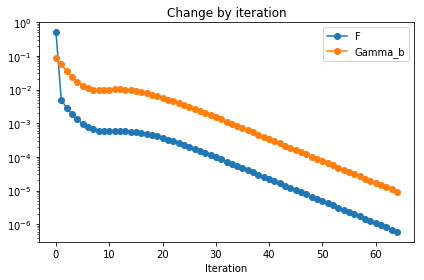

In [17]:
plt.figure();
plt.plot(max_abs_delta_F[max_abs_delta_F>0], "-o");
plt.plot(max_abs_delta_Gamma_b[max_abs_delta_Gamma_b>0], "-o");
plt.legend(("F", "Gamma_b"));
plt.title("Change by iteration");
plt.yscale("log");
plt.xlabel("Iteration");
plt.tight_layout();
plt.savefig("figures/Convergence_plot.pdf"); 

In [38]:
fact_mean = np.mean(fact_ret,axis=1)
fact_var= np.cov(fact_ret)

In [39]:
np.sqrt(fact_mean.T.dot(np.linalg.inv(fact_var)).dot(fact_mean))*np.sqrt(12)

0.27372468807996764

In [27]:
port_mean = np.mean(port_ret[0,:])
port_var= np.cov(port_ret[0,:])
port_mean/np.sqrt(port_var)*np.sqrt(12)

-0.15191317942864827

## All stocks

In [6]:
Zts = np.array(Zts_save, copy = True)
Zt_cov = np.zeros((Zts.shape[1],Zts.shape[1],Zts.shape[2]))
x_t = np.zeros((Zts.shape[1],Zts.shape[2]))
for i in range(Zts.shape[2]):
    Zt = Zts[:,:,i]
    Zt_cov[:,:,i] = (Zt.T).dot(Zt)
    if i<Zts.shape[2]-1:
        x_t[:,i] = (Zt.T).dot(rs[:,i+1])

In [9]:
%load_ext autoreload
%autoreload 2
from ipca_restricted import ipca_restricted
K=5
F_1, Gamma_b_0, max_abs_delta_F, max_abs_delta_Gamma_b,_,_ = ipca_restricted(Zts, Zt_cov, x_t, K, T,init=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
iter 0 	max_abs_delta_F 0.5038841055081935 	max_abs_delta_Gamma_b 0.04502946280795073
iter 100 	max_abs_delta_F 2.4920771796059394e-07 	max_abs_delta_Gamma_b 3.859218169630647e-06
iter 198 	max_abs_delta_F 5.988337510216402e-08 	max_abs_delta_Gamma_b 9.876348577165518e-07
Elapsed time 70.64337730407715


In [10]:
#IN SAMPLE R2
model_rt = np.zeros((rs.shape[0],rs.shape[1]-1))
for i_t in range(model_rt.shape[1]):
    model_rt[:,i_t] = Zts[:,:,i_t].dot(Gamma_b_0.dot(F_1[:,i_t+1]))
total_noise = np.linalg.norm(rs[:,1:] - model_rt)**2
rt_var = np.linalg.norm(rs[:,1:])**2
total_r2 = 1- total_noise/rt_var
print(total_r2) 

0.003785902493081972


## Things about $Z_t'Z_t$

In [14]:
mat = np.zeros_like(Zt_cov)
diagonals = np.zeros(Zts.shape[1:])
singular_values = np.zeros(Zts.shape[1:])
traces = np.zeros(Zts.shape[2])
negative_off_diag = np.zeros(Zts.shape[2])
for i in range(Zts.shape[2]):
    #mat[:,:,i] = (np.linalg.inv(np.linalg.cholesky(Zts[:,:,i].T.dot(Zts[:,:,i]))).dot(Zts[:,:,i].T)).T
    mat[:,:,i] = np.linalg.inv(Zt_cov[:,:,i]/np.sum(stock_presence[:,i]))
    #mat = Zts[:,:,i].T
    U, S, V = np.linalg.svd(mat[:,:,i])
    singular_values[:,i] = S
    #traces[i] = np.trace(mat[:,:,i])
    traces[i] = np.sum(S)
    diagonals[:,i] = np.diag(mat[:,:,i])
    #diagonals[:,i] = mat[:,0,i]
    #negative_off_diag[i] = np.sum(mat < 0)/Zts.shape[1]/(Zts.shape[1]-1)
    #negative_off_diag[i] = np.sum(mat[mat < 0])

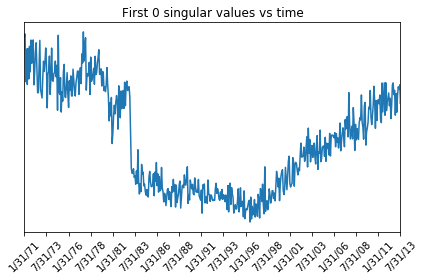

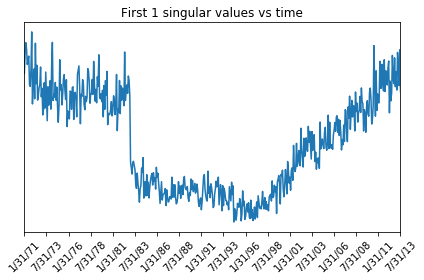

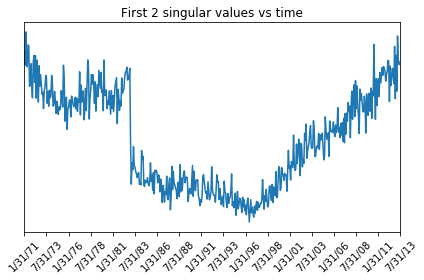

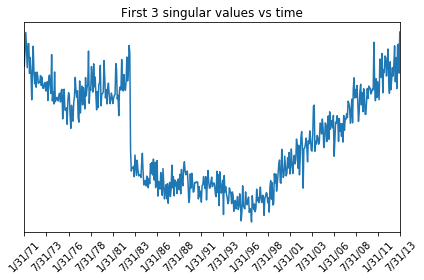

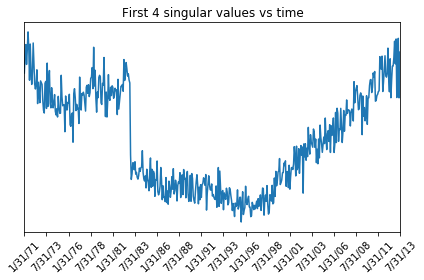

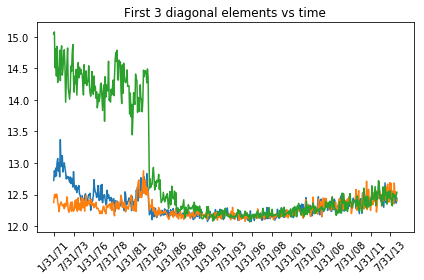

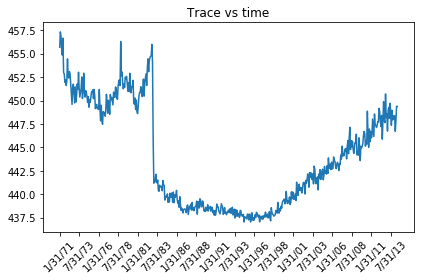

In [17]:
for i in range(5):
    first_n = i
    plt.figure(); plt.plot(singular_values.T[:,first_n]);
   # plt.ylim([0.00019,0.0005]); 
    plt.title("First "+str(first_n)+" singular values vs time");
    select_labels = np.arange(singular_values.shape[1]//1000000,singular_values.shape[1],30);
    plt.xlim([select_labels[0], select_labels[-1]]);
    plt.yscale("log");
    plt.xticks(select_labels, labels=[Ts[i] for i in select_labels], rotation=45);
    plt.tight_layout(); 

first_n = 3
plt.figure(); plt.plot(diagonals.T[:,:first_n]);
plt.title("First "+str(first_n)+" diagonal elements vs time");
select_labels = np.arange(0,singular_values.shape[1],30);
plt.xticks(select_labels, labels=[Ts[i] for i in select_labels], rotation=45);
plt.tight_layout(); 

plt.figure(); plt.plot(traces);
plt.title("Trace vs time");
select_labels = np.arange(0,singular_values.shape[1],30);
plt.xticks(select_labels, labels=[Ts[i] for i in select_labels], rotation=45);
plt.tight_layout(); 

# plt.figure(); plt.plot(negative_off_diag);
# plt.title("Negative values off diagonals vs time");
# select_labels = np.arange(0,singular_values.shape[1],30);
# plt.xticks(select_labels, labels=[Ts[i] for i in select_labels], rotation=45);
# plt.tight_layout(); 

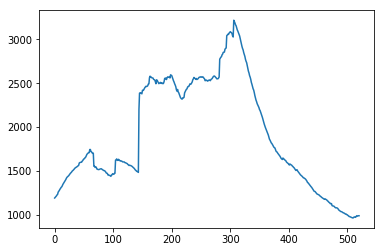

In [50]:
plt.plot(np.sum(stock_presence,axis=0))

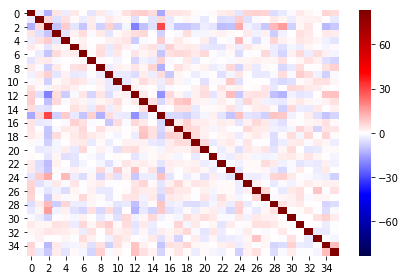

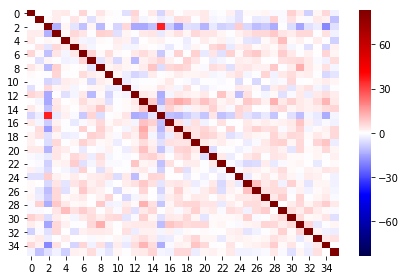

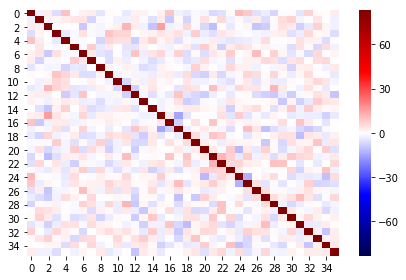

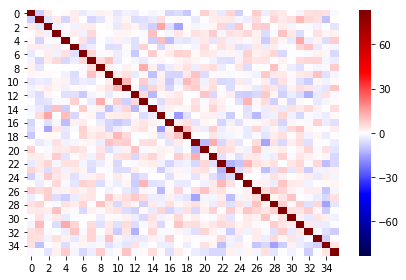

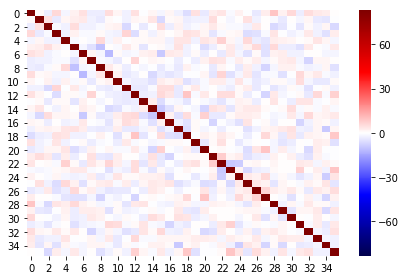

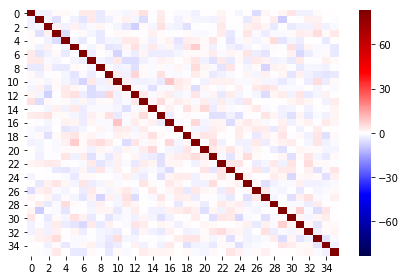

In [19]:
for i in range(0, Zt_cov.shape[2], 100):
#     mat = np.linalg.inv(Zt_cov[:,:,i])
    mat = Zt_cov[:,:,i]
#    vlimit = np.amax(np.abs(mat));
#     vlimit = .001
    
    plt.figure(); 
    sns.heatmap(mat, cmap="seismic", vmin=-vlimit, vmax=vlimit);
    plt.tight_layout();

In [78]:
Zt_cov[:,:,0]

array([[80548.81614223, 79701.63895903, 79657.27684209, ...,
        79754.11884209, 79763.62070218, 74152.91578262],
       [79701.63895903, 80548.81614223, 79850.54368458, ...,
        79729.06251564, 79825.62419747, 74081.60551269],
       [79657.27684209, 79850.54368458, 80548.81614223, ...,
        79716.03995982, 79747.56268096, 74146.8887671 ],
       ...,
       [79754.11884209, 79729.06251564, 79716.03995982, ...,
        80548.81614223, 79734.65295288, 74133.58359629],
       [79763.62070218, 79825.62419747, 79747.56268096, ...,
        79734.65295288, 80548.81614223, 74081.35759749],
       [74152.91578262, 74081.60551269, 74146.8887671 , ...,
        74133.58359629, 74081.35759749, 80548.81614223]])